In [ ]:
from typing import Annotated
from langchain_openai import ChatOpenAI
from langchain_experimental.utilities import PythonREPL
from langchain.tools import tool
from xml.etree import ElementTree
from duckduckgo_search import DDGS

# llm = ChatOpenAI(
#     base_url="https://lxxxxx.enovo.com/v1/", 
#     api_key="sxxxxxxxwW",
#     model_name="qwen2.5-instruct"
#     )

llm = ChatOpenAI(
    base_url="https://api.deepseek.com", 
    api_key="sk-3b458ee0624f41e1b8c589e74be23e44",
    model_name="deepseek-chat"
    )
   
@tool
def duckduckgo_search_tool(query: str) -> list:
    """Search DuckDuckGo for the given query and return a list of results."""
    try:
        # Use DDGS for robust search, region set to 'cn-zh' for Chinese
        results = DDGS().text(query, region="cn-zh", safesearch="off", max_results=10)
        output = []
        for item in results:
            title = item.get('title')
            url = item.get('href')
            if title and url:
                output.append(f"{title}: {url}")
        return output or ["DuckDuckGo: No relevant results found."]
    except Exception as e:
        return [f"DuckDuckGo search error: {e}"]

# This executes code locally, which can be unsafe
repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return result_str

result = llm.invoke('Hello, how are you?')
result.pretty_print()


================================== Ai Message ==================================

Hello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with anything you need. How about you? How are you doing today? 😊


In [37]:
### Testing structured output
from pydantic import BaseModel
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from langchain.schema import HumanMessage

class Router(BaseModel):
    intent: str
    confidence: float

parser = PydanticOutputParser(pydantic_object=Router)

# 定义 Prompt 模板
prompt = PromptTemplate(
    template="请根据下面的用户输入识别意图，并以JSON格式输出：\n{format_instructions}\n\n用户输入：{query}",
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

# 消息内容
messages = [
    {"role": "user", "content": "我想订一张去上海的火车票"}
]

# structured_llm = llm.with_structured_output(Router)
# response = structured_llm.invoke(messages)

### 渲染 prompt
formatted_prompt = prompt.format_prompt(query="我想订一张去上海的火车票")
### 调用模型（注意：invoke 的输入必须是 ChatMessage 类型）
response = llm.invoke([HumanMessage(content=formatted_prompt.to_string())])
print(response)
### 结构化解析
response = parser.parse(response.content)
print(response)

content='```json\n{\n  "intent": "book_train_ticket",\n  "confidence": 0.95\n}\n```' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 196, 'total_tokens': 222, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 192}, 'prompt_cache_hit_tokens': 192, 'prompt_cache_miss_tokens': 4}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_8802369eaa_prod0425fp8', 'id': '292948b4-bb2a-4f81-8fad-53595d7613ac', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None} id='run--73f590d0-65d3-4d4f-b15a-a53d7270ff44-0' usage_metadata={'input_tokens': 196, 'output_tokens': 26, 'total_tokens': 222, 'input_token_details': {'cache_read': 192}, 'output_token_details': {}}
intent='book_train_ticket' confidence=0.95


In [23]:
from typing import List, Optional, Literal
from langchain_core.language_models.chat_models import BaseChatModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages
from typing import TypedDict

from langchain.output_parsers.openai_tools import JsonOutputKeyToolsParser
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel

class State(MessagesState):
    next: str


def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    class Router(BaseModel):
        """Worker to route to next. If no workers needed, route to FINISH."""

        next: Literal[*options]
    

    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            goto = END

        return Command(goto=goto, update={"next": goto})

    return supervisor_node


supervisor = make_supervisor_node(llm, ["researcher", "paper_writer"])

In [24]:
def researcher(state: State) -> Command[Literal["supervisor"]]:
    response = research_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="researcher"
                )
            ]
        },
        goto="supervisor",
    )


def paper_writer(state: State) -> Command[Literal["supervisor"]]:
    response = paper_writing_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="paper_writer"
                )
            ]
        },
        goto="supervisor",
    )

def build_graph():
    # Define the graph.
    builder = StateGraph(State)
    builder.add_node("supervisor", supervisor)
    builder.add_node("researcher", researcher)
    builder.add_node("paper_writer", paper_writer)

    builder.add_edge(START, "supervisor")
    graph = builder.compile()
    return graph

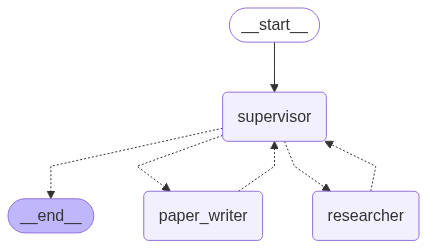

In [25]:
from IPython.display import Image, display

graph = build_graph()
display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
inputs = {
    "messages": [
        ("user", "Research AI agents and write a brief report about them.")
    ],
}

for s in graph.stream(
    inputs,
    {"recursion_limit": 150},
    stream_mode="values"
):
    s['messages'][-1].pretty_print()

================================ Human Message =================================

Research AI agents and write a brief report about them.


UnprocessableEntityError: Failed to deserialize the JSON body into the target type: response_format: response_format.type `json_schema` is unavailable now at line 1 column 814